# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
import cv2
import skimage
from skimage import transform
import datetime
import os
import pandas as pd
import random
from skimage.filters import gaussian
from skimage.util import random_noise
from sys import platform
if platform == "darwin":
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

We set the random seed so that the results don't vary drastically.

In [3]:
#Sometimes this does not hide the warnings, we may need to execute this multiple times.
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import backend as K
import random as rn
np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)
%matplotlib inline


# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)

sns.set_style(style='dark')
sns.set_context("notebook")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
batch_size = 10
base_path = 'Project_data/'

In [6]:
train_doc = np.random.permutation(open(base_path+'train.csv').readlines())
val_doc = np.random.permutation(open(base_path + 'val.csv').readlines())

# Explore Data

### Settings for data exploration and generator

In [7]:
enable_data_explore = False
test_generator = False

In [8]:
def read_data(source):
    df = pd.read_csv(source, header=None)
    df[['folder', 'name', 'class']] = df[0].str.split(';', expand=True)
    return df

In [9]:
def explore_data(source):
    df = read_data(source)
    print(df['class'].value_counts())

In [10]:
# Train data
if enable_data_explore:
    explore_data(base_path+'train.csv')

In [11]:
# Val data
if enable_data_explore: 
    explore_data(base_path+'val.csv')

We can see that data is evenly balance across all the classes.

In [12]:
def get_image(folder, index):
    image_name = os.listdir(folder)[index]
    image = skimage.io.imread(folder + "/" + image_name).astype(np.float32)
    return image

In [13]:
def get_image_dimensions(row, source_path):
    y, x, _ = get_image(source_path + row['folder'], 0).shape
    return str(x) + "-" + str(y)

In [14]:
def explore_images(source_file, source_path):
    df = read_data(source_file)
    df['shape'] = df.apply(get_image_dimensions, axis=1, args=[source_path])
    print(df['shape'].value_counts())
    return df

In [15]:
# Exploring Train images
if enable_data_explore:
    explore_images(base_path+'train.csv', base_path+'train/')

In [16]:
# Exploring Val images
if enable_data_explore:
    explore_images(base_path+'val.csv', base_path+'val/')

We can see there are two dimensions of the images **160*120** and **360*360**. We will need to bring the images to same dimension when passing from generator.

## We will resize the bigger image to 120X120 and smaller will be cropped to 120X120

In [17]:
starting_image_shape = (120, 120)

Reference 
- https://medium.com/@ODSC/image-augmentation-for-convolutional-neural-networks-18319e1291c
- https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/
- https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/

In [18]:
#ia.seed(4)

In [19]:
def flip(image):
    return np.fliplr(image)

In [20]:
def rotate(image):
    return transform.rotate(image,random.uniform(-10,10))

In [21]:
def blur(image):
    return gaussian(image, sigma=1, multichannel=True)

In [22]:
def noise(image):
    return random_noise(image, var=0.1**2)

In [23]:
def scale(image):
    scale_image = iaa.PerspectiveTransform(scale=(0.01, 0.10))
    return scale_image(image=image)

In [24]:
def resize_image(image,image_shape):
    return cv2.resize(image, image_shape, interpolation = cv2.INTER_AREA)

In [25]:
image_augmentors = [rotate, blur, noise, scale, flip]
#image_augmentors = [scale]

In [26]:
def crop(image):
    return image[0:120, 20:140]

In [27]:
def modify_image(image, image_shape):
    if (image.shape[0] == image.shape[1]):
        return resize_image(image, image_shape)
    else:
        return resize_image(crop(image), image_shape)

In [28]:
def crop_center(img, cropx, cropy):
    print(img.shape)
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]

## Show image with different image aumentations

In [29]:
if enable_data_explore:
    sample_size = 5
    df = explore_images(base_path + 'train.csv', base_path + 'train/')
    sample = df.sample(n=sample_size)
    fig, axs = plt.subplots(1 + len(image_augmentors),
                            sample_size,
                            figsize=(14, 20))
    plot_index = 1
    for index, row in sample.head(n=sample_size).iterrows():
        image = get_image(base_path + 'train/' + row['folder'], 5)
        plt.subplot(1 + len(image_augmentors),
                    sample_size,
                    plot_index,
                    title=row['shape'])
        plt.imshow(image.astype('uint8'), interpolation='nearest')
        image = modify_image(image, starting_image_shape) / 255
        size = plot_index
        for i, image_augmentor in enumerate(image_augmentors):
            size = size + sample_size
            plt.subplot(1 + len(image_augmentors),
                        sample_size,
                        size,
                        title=image_augmentor.__name__)
            current_image = image_augmentor(image)
            plt.imshow(current_image, cmap=None)
        plot_index += 1

    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [30]:
train_path = base_path + 'train'
val_path = base_path + 'val'

In [31]:
def nomalize(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

In [32]:
random.seed(30)


def get_batch_data(t, source_path, batch, batch_size, number_of_folders,
                   img_idx, image_shape, augmentors, test_generator, verbose,
                   processedImagesSet, labels_list):
    if verbose:
        print("Executing batch ", batch)
        print("Augmentors ", len(augmentors))
    is_training = len(augmentors) != 0
    batch_data = np.zeros(
        (number_of_folders, len(img_idx), image_shape[0], image_shape[1], 3))
    # batch_labels is the one hot representation of the output
    batch_labels = np.zeros((number_of_folders, 5))
    if is_training:
        aug_batch_data = []
        aug_batch_labels = []
        # Initializing data and labels for each augmentor
        for aug in augmentors:
            aug_batch_data.append(
                np.zeros((number_of_folders, len(img_idx), image_shape[0],
                          image_shape[1], 3)))
            aug_batch_labels.append(np.zeros((number_of_folders, 5)))
    for folder in range(number_of_folders):  # iterate over the batch_size
        if verbose:
            print("Executing folder ", folder)
        # read all the images in the folder
        imgs = os.listdir(source_path + '/' +
                          t[folder + (batch * batch_size)].split(';')[0])
        # Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx):
            if test_generator:
                image_path = source_path + '/' + \
                    t[folder + (batch * batch_size)
                      ].strip().split(';')[0] + "_" + str(item)
                assert image_path not in processedImagesSet, "Duplicate image should not be added"
                processedImagesSet.add(image_path)
            image = get_image(
                source_path + '/' +
                t[folder + (batch * batch_size)].strip().split(';')[0], item)

            # Here, we are croping and resizing the image based on its dimensions
            image = modify_image(image, image_shape)
            # normalize image
            image = image / 255
            # crop the images and resize them. Note that the images are of 2 different shape
            # and the conv3D will throw error if the inputs in a batch have different shapes
            # normalise and feed in the image
            batch_data[folder, idx, :, :, 0] = image[:, :, 0]
            # normalise and feed in the image
            batch_data[folder, idx, :, :, 1] = image[:, :, 1]
            # normalise and feed in the image
            batch_data[folder, idx, :, :, 2] = image[:, :, 2]
            if is_training:
                for index, augmentor in enumerate(augmentors):
                    augmented_image = augmentor(image)
                    aug_batch_data[index][folder, idx, :, :,
                                          0] = augmented_image[:, :, 0]
                    aug_batch_data[index][folder, idx, :, :,
                                          1] = augmented_image[:, :, 1]
                    aug_batch_data[index][folder, idx, :, :,
                                          2] = augmented_image[:, :, 2]
        current_class = int(t[folder +
                              (batch * batch_size)].strip().split(';')[2])
        batch_labels[folder, current_class] = 1
        if test_generator:
            labels_list.append({
                'l_type': 'n',
                'old_label': current_class,
                'new_label': current_class
            })
        if is_training:
            for index, augmentor in enumerate(augmentors):
                # When flip augmentation is used, left swip will change to right swipe
                if augmentor.__name__ == flip.__name__:
                    if current_class == 0:
                        new_class = 1
                    elif current_class == 1:
                        new_class = 0
                    else:
                        new_class = current_class
                    aug_batch_labels[index][folder, new_class] = 1
                    if test_generator:
                        labels_list.append({
                            'l_type': augmentor.__name__,
                            'old_label': current_class,
                            'new_label': new_class
                        })
                else:
                    aug_batch_labels[index][folder, current_class] = 1
                    if test_generator:
                        labels_list.append({
                            'l_type': augmentor.__name__,
                            'old_label': current_class,
                            'new_label': current_class
                        })
    if is_training:
        for index, augmentor in enumerate(augmentors):
            batch_data = np.append(batch_data, aug_batch_data[index], axis=0)
            batch_labels = np.append(batch_labels,
                                     aug_batch_labels[index],
                                     axis=0)
    return batch_data, batch_labels

In [33]:
def generator(source_path,
              folder_list,
              batch_size,
              list_of_frames,
              image_shape,
              augmentors=[],
              test_generator=False,
              verbose=False,
              processedImagesSet=set(),
              labels_list=[]):
    print('Source path = ', source_path, '; batch size =', batch_size)
    # create a list of image numbers you want to use for a particular video
    img_idx = list_of_frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size  # calculate the number of batches
        if verbose:
            print("Number of batches ", num_batches)
        for batch in range(
                num_batches):  # we iterate over the number of batches
            yield get_batch_data(t, source_path, batch, batch_size, batch_size,
                                 img_idx, image_shape, augmentors,
                                 test_generator, verbose, processedImagesSet,
                                 labels_list)

        remaining_folder = len(t) % batch_size
        if remaining_folder > 0:
            if verbose:
                print("Executing remaining batch")
            yield get_batch_data(t, source_path, num_batches, batch_size,
                                 remaining_folder, img_idx, image_shape,
                                 augmentors, test_generator, verbose,
                                 processedImagesSet, labels_list)
        if test_generator:
            break

# Testing image generator

In [34]:
def test_image_generator(path,
                         data,
                         number_of_frames,
                         current_batch_size,
                         augmentors=[]):
    processedImagesSet = set()
    labels_list = []

    generator_to_validate = generator(path,
                                      data,
                                      current_batch_size,
                                      list(range(0, number_of_frames)),
                                      starting_image_shape,
                                      augmentors=augmentors,
                                      test_generator=True,
                                      verbose=False,
                                      processedImagesSet=processedImagesSet,
                                      labels_list=labels_list)
    total_images = len(data) * number_of_frames
    image_count = 0
    label_count = 0
    index = 0
    whole = len(data) // current_batch_size
    for data in generator_to_validate:
        image_count += data[0].shape[0] * data[0].shape[1]
        label_count += data[1].shape[0] * data[1].shape[1]
        if index >= whole:
            break
        consumed_batch = 0
        for b in range(0, current_batch_size):

            label = labels_list[index * data[1].shape[0] + consumed_batch +
                                consumed_batch * len(augmentors)]
            found_label = np.nonzero(data[1][b])[0]
            assert found_label == label[
                "old_label"], "For normal, it should be same"

            for l in range(0, len(augmentors)):
                label = labels_list[index * data[1].shape[0] + consumed_batch +
                                    consumed_batch * len(augmentors) + l + 1]
                aug_index = b + l * current_batch_size + current_batch_size
                found_label = np.nonzero(data[1][aug_index])[0]
                if label['l_type'] == flip.__name__:
                    if label["old_label"] == 0:
                        assert found_label == label[
                            "new_label"] and found_label == 1, "For Flip, 0 should changed to 1"
                    elif label["old_label"] == 1:
                        assert found_label == label[
                            "new_label"] and found_label == 0, "For Flip, 1 should changed to 0"
                    else:
                        assert found_label == label[
                            "old_label"], "For other flips, it should be same"
                else:
                    assert found_label == label[
                        "old_label"], "For other augmentation, it should be same"
            consumed_batch += 1
        index += 1

    print("Images generated: ", image_count)
    print("Images should be generated: ",
          total_images + (total_images) * len(augmentors))
    print("Label generated: ", label_count)
    assert label_count == len(labels_list) * \
        5, "The generator did not return all lables"
    if len(augmentors) == 0:
        assert len(
            processedImagesSet
        ) == image_count, "the generator did not return all the images"
        assert image_count == total_images + \
            (total_images) * \
            len(augmentors), "the generator did not return all the images"

In [35]:
if test_generator:
    test_image_generator(train_path, train_doc, 10, 16)
    test_image_generator(train_path, train_doc, 10, 10)
    test_image_generator(val_path, val_doc, 10, 16, [flip, scale, rotate])
    test_image_generator(val_path, val_doc, 10, 10, augmentors=[flip])
else:
    print("skipping testing the generator")

skipping testing the generator


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [36]:
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 5  # choose the number of epochs
print('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [37]:
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers
from keras.regularizers import l2

In [38]:
def get_optimizer(optimizer, learning_rate=0.01, decay=False):
    if optimizer == "sgd":
        print("SGD optimizer with learning rate: ", learning_rate, decay)
        if decay:
            model_optimizer = optimizers.SGD(lr=learning_rate, decay=0.00001)
        else:
            model_optimizer = optimizers.SGD(lr=learning_rate)
    else:
        print("ADAM optimizer with learning rate: ", learning_rate, decay)
        if decay:
            model_optimizer = optimizers.Adam(lr=learning_rate, decay=0.00001)
        else:
            model_optimizer = optimizers.Adam(lr=learning_rate)

    return model_optimizer

### This approach of running model and collecting metrics is adopted from our previous project `Telecom Churn case study`

In [39]:
def convert_history_to_data_frame(model_name, history):
    df = pd.DataFrame.from_dict(history)
    df['epoch'] = df.index
    df['name'] = model_name
    return df

In [40]:
class ModelLayer:
    def __init__(self, params):
        self.is_conv_layer = params.get("is_conv_layer", True)
        self.dropout = params.get("dropout", None)
        self.batch_normalize = params.get("batch_normalize", False)
        self.layer_dim = params["layer_dim"]
        self.is_input_layer = params.get("is_input_layer", False)
        self.filter = params.get("filter", (3,3,3)  if self.is_conv_layer else None)
        self.l2_regularize = params.get("l2_regularize", None)

    def _print(self):
        attrs = vars(self)
        print(", ".join([key + "->" + str(value)
                         for key, value in attrs.items() if value is not None]))

In [41]:
class ModelParam:
    def __init__(self, params):
        self.learning_rate = params["learning_rate"]
        self.optmizer = params["optmizer"]
        self.batch_size = params["batch_size"]
        if type(params["frames"]) is tuple:
            self.video_frames = list(range(params["frames"][0], params["frames"][1]))
        else:
            self.video_frames = np.round(np.linspace(0, 29, params["frames"])).astype(int)
        
        self.learning_rate = params["learning_rate"]
        self.num_epochs = params["num_epochs"]
        self.image_shape = params["image_shape"]
        self.decay_learning_rate = params.get("decay_learning_rate", False)
        self.augmentors = params.get("augmentors", [])
        self.layers = params["layers"]
        self.activation = params.get("activation", "relu")

        dropout = (len([l for l in self.layers if l.dropout is not None]) > 0)
        batch_normalize = (
            len([l for l in self.layers if l.batch_normalize]) > 0)

        regularize = batch_normalize or dropout

        self.rnn_layer_type = params.get("rnn_layer_type", None)
        self.rnn_layers = params.get("rnn_layers", None)
        self.name = params["model_name"] + "_" + self.optmizer+"_"+str(len(self.video_frames))+"_frames" + "_" + str(self.batch_size*max([len(self.augmentors),1]))+"_batch_size" + "_" + str(
            len(self.layers)) + "_" + "layers" + "_" + str(
                self.num_epochs) + "_" + "epochs" + "_" + (
                    "regularized" if regularize else "not_regularized")
        self.is_rnn = self.rnn_layer_type is not None
        self.input_shape = (len(self.video_frames), self.image_shape[0],
                            self.image_shape[1], 3)
        if (regularize):
            if (batch_normalize):
                self.name = self.name + "_BN"
            if (dropout):
                self.name = self.name + "_DO"

    def _print(self):
        attrs = vars(self)
        print("Model Params: ")
        print("********************************************************")
        for key, value in attrs.items():
            if key == "augmentors":
                print(key, '->', [a.__name__ for a in value])
            elif key == "layers":
                print("Layers: ")
                print("=======================================================")
                for i in value:
                    print("----------------------------------------------------")
                    i._print()
                    print("----------------------------------------------------")
                print("=======================================================")
            else:
                print(key, '->', value)
        print("********************************************************")

Reference: https://www.machinecurve.com/index.php/2019/10/18/a-simple-conv3d-example-with-keras/

In [42]:
def create_cnn_model(model_param):
    model = Sequential()
    conv_layers = [l for l in model_param.layers if l.is_conv_layer]
    connected_layers = [l for l in model_param.layers if not l.is_conv_layer]

    for l in conv_layers:
        if l.is_input_layer:
            model.add(Conv3D(l.layer_dim,
                             kernel_size=l.filter,
                             input_shape=model_param.input_shape,
                             padding='same'))
        else:
            model.add(Conv3D(l.layer_dim,
                             kernel_size=l.filter,
                             padding='same'))
        if l.batch_normalize:
            model.add(BatchNormalization())
        model.add(Activation(model_param.activation))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        if l.dropout:
            model.add(Dropout(l.dropout))

    model.add(Flatten())
    for l in connected_layers:
        if l.l2_regularize:
            model.add(Dense(l.layer_dim, kernel_regularizer=l2(l.l2_regularize)))
        else:
            model.add(Dense(l.layer_dim))

        model.add(Activation(model_param.activation))
        if l.dropout:
            model.add(Dropout(l.dropout))

    model.add(Dense(5, activation='softmax'))
    return model

In [43]:
def run_model(model, params, show_summary=True):
    params._print()

    model_optimizer = get_optimizer(params.optmizer,
                                    learning_rate=params.learning_rate,
                                    decay=params.decay_learning_rate)

    model.compile(optimizer=model_optimizer,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

    if show_summary:
        print(model.summary())

    curr_dt_time = datetime.datetime.now()

    train_generator = generator(train_path,
                                train_doc,
                                params.batch_size,
                                list_of_frames=params.video_frames,
                                image_shape=params.image_shape,
                                augmentors=params.augmentors)
    val_generator = generator(val_path,
                              val_doc,
                              params.batch_size,
                              list_of_frames=params.video_frames,
                              image_shape=params.image_shape,
                              augmentors=[])
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(
        ' ', '').replace(':', '_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + \
        'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=False,
                                 mode='auto',
                                 period=1)

    LR = ReduceLROnPlateau(monitor='val_loss',
                           factor=0.5,
                           patience=2,
                           verbose=1)  # write the REducelronplateau code here
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8)
    callbacks_list = [checkpoint, LR, es]
    if (num_train_sequences % params.batch_size) == 0:
        steps_per_epoch = int(num_train_sequences / params.batch_size)
    else:
        steps_per_epoch = (num_train_sequences // params.batch_size) + 1

    if (num_val_sequences % params.batch_size) == 0:
        validation_steps = int(num_val_sequences / params.batch_size)
    else:
        validation_steps = (num_val_sequences // params.batch_size) + 1

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=params.num_epochs,
                                  verbose=1,
                                  callbacks=callbacks_list,
                                  validation_data=val_generator,
                                  validation_steps=validation_steps,
                                  class_weight=None,
                                  workers=1,
                                  initial_epoch=0)
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'],
             label='Categorical crossentropy (training data)')
    plt.plot(history.history['val_loss'],
             label='Categorical crossentropy (validation data)')
    plt.plot(history.history['categorical_accuracy'],
             label='Accuracy (training data)')
    plt.plot(history.history['val_categorical_accuracy'],
             label='Accuracy (validation data)')

    plt.title('Model performance: ' + params.name)
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()
    return convert_history_to_data_frame(params.name, history.history)

In [44]:
model_stats = None

In [45]:
def collect_stats(df):
    global model_stats
    if model_stats is not None:
        model_stats = pd.concat([model_stats, df], axis=0)
    else:
        model_stats = df
    return df

In [46]:
def sub_plot(x1,
             y1,
             x2,
             y2,
             title,
             index,
             x_label="Number of epochs",
             y_label='Loss value'):
    plt.subplot(2, 2, index, title=title)

    plt.plot(x1, y1, label=first_model)
    plt.plot(x2, y2, label=second_model)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(loc="upper left")


def plot_graphs(first_model, second_model, number_of_epochs):
    first_model_data = model_stats.loc[model_stats['name'] ==
                                       first_model][0:number_of_epochs]
    second_model_data = model_stats.loc[model_stats['name'] ==
                                        second_model][0:number_of_epochs]

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    sub_plot(first_model_data['epoch'], first_model_data['loss'],
             second_model_data['epoch'], second_model_data['loss'],
             "Training Loss", 1)

    sub_plot(first_model_data['epoch'], first_model_data['val_loss'],
             second_model_data['epoch'], second_model_data['val_loss'],
             "Validation Loss", 3)

    sub_plot(first_model_data['epoch'],
             first_model_data['categorical_accuracy'],
             second_model_data['epoch'],
             second_model_data['categorical_accuracy'],
             "Training Accuracy",
             2,
             y_label='Accuracy')

    sub_plot(first_model_data['epoch'],
             first_model_data['val_categorical_accuracy'],
             second_model_data['epoch'],
             second_model_data['val_categorical_accuracy'],
             "Validation Accuracy",
             4,
             y_label='Accuracy')
    plt.show()

#### Let us start with 4 layer CNN model with no regularization and batch size 10

## Model 1

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> sgd
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 20
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->False, layer_dim->8, filter->(3, 3, 3), is_input_layer->True
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, batch_normalize->False, layer_dim->16, filter->(3, 3, 3), is_input_layer->False
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, batch_normalize->False, layer_dim->32, filter->(3, 3, 3), is_input_layer->False
----------------------------------------------------
----------------------------

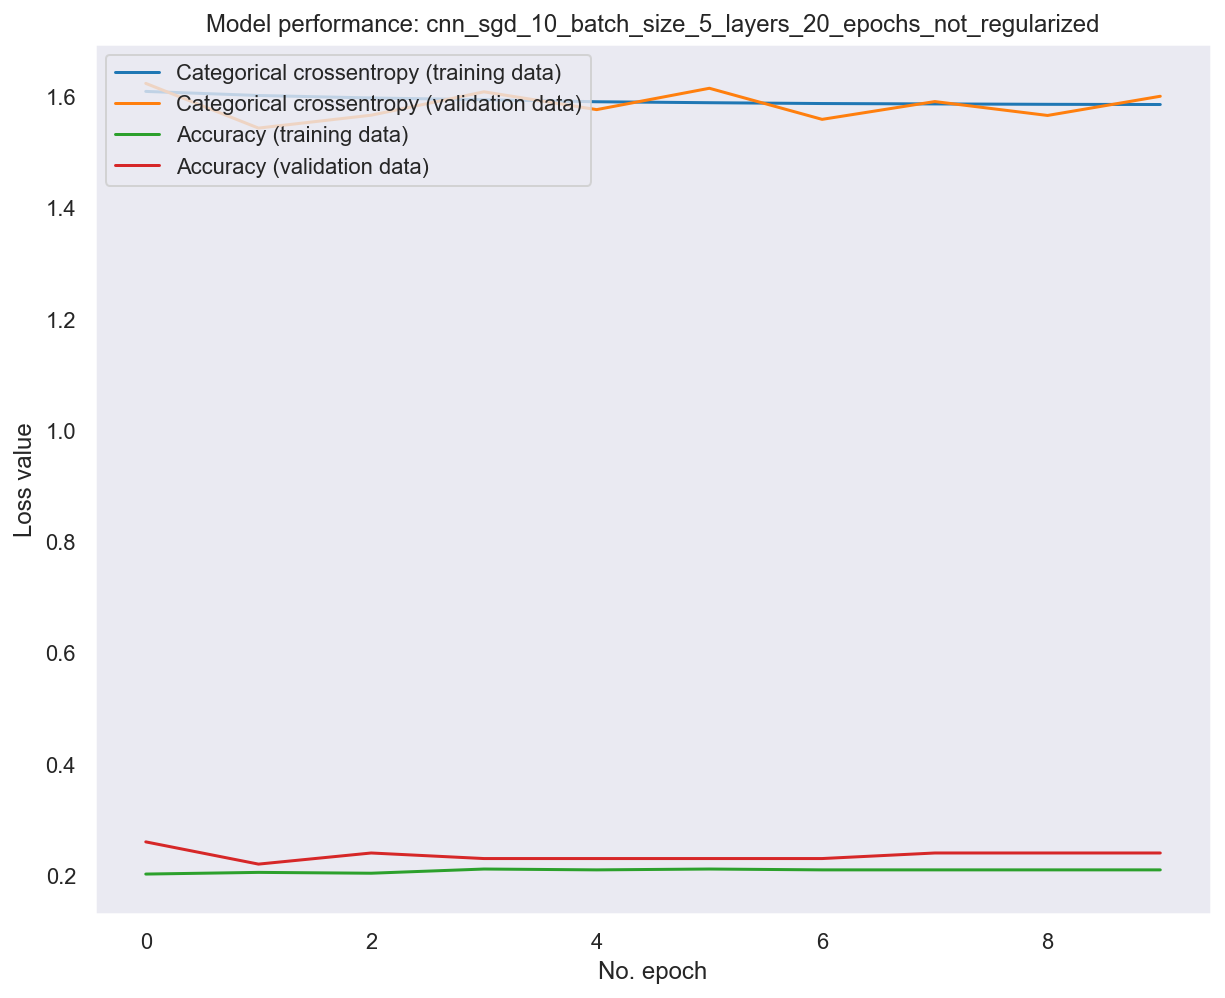

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.6235,0.2600,1.6091,0.2021,0.0010,0,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...
1,1.5431,0.2200,1.6017,0.2051,0.0010,1,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...
2,1.5663,0.2400,1.5973,0.2036,0.0010,2,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...
3,1.6083,0.2300,1.5942,0.2112,0.0010,3,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...
4,1.5763,0.2300,1.5905,0.2097,0.0005,4,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...
5,1.6147,0.2300,1.5888,0.2112,0.0005,5,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...
6,1.5588,0.2300,1.5873,0.2097,0.0003,6,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...
7,1.5908,0.2400,1.5866,0.2097,0.0003,7,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...
8,1.5659,0.2400,1.5859,0.2097,0.0001,8,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...
9,1.6004,0.2400,1.5855,0.2097,0.0001,9,cnn_sgd_10_batch_size_5_layers_20_epochs_not_r...


In [48]:
params = {
    "learning_rate": 0.001,
    "optmizer": "sgd",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 20,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True
        }),
        ModelLayer({
            "layer_dim": 16,
        }),
        ModelLayer({
            "layer_dim": 32,
        }),
        ModelLayer({
            "layer_dim": 64,
        }),
        ModelLayer({
            "layer_dim": 64,
            "is_conv_layer":False
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

## Model 2

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 20
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->False, layer_dim->8, filter->(3, 3, 3), is_input_layer->True
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, batch_normalize->False, layer_dim->16, filter->(3, 3, 3), is_input_layer->False
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, batch_normalize->False, layer_dim->32, filter->(3, 3, 3), is_input_layer->False
----------------------------------------------------
---------------------------

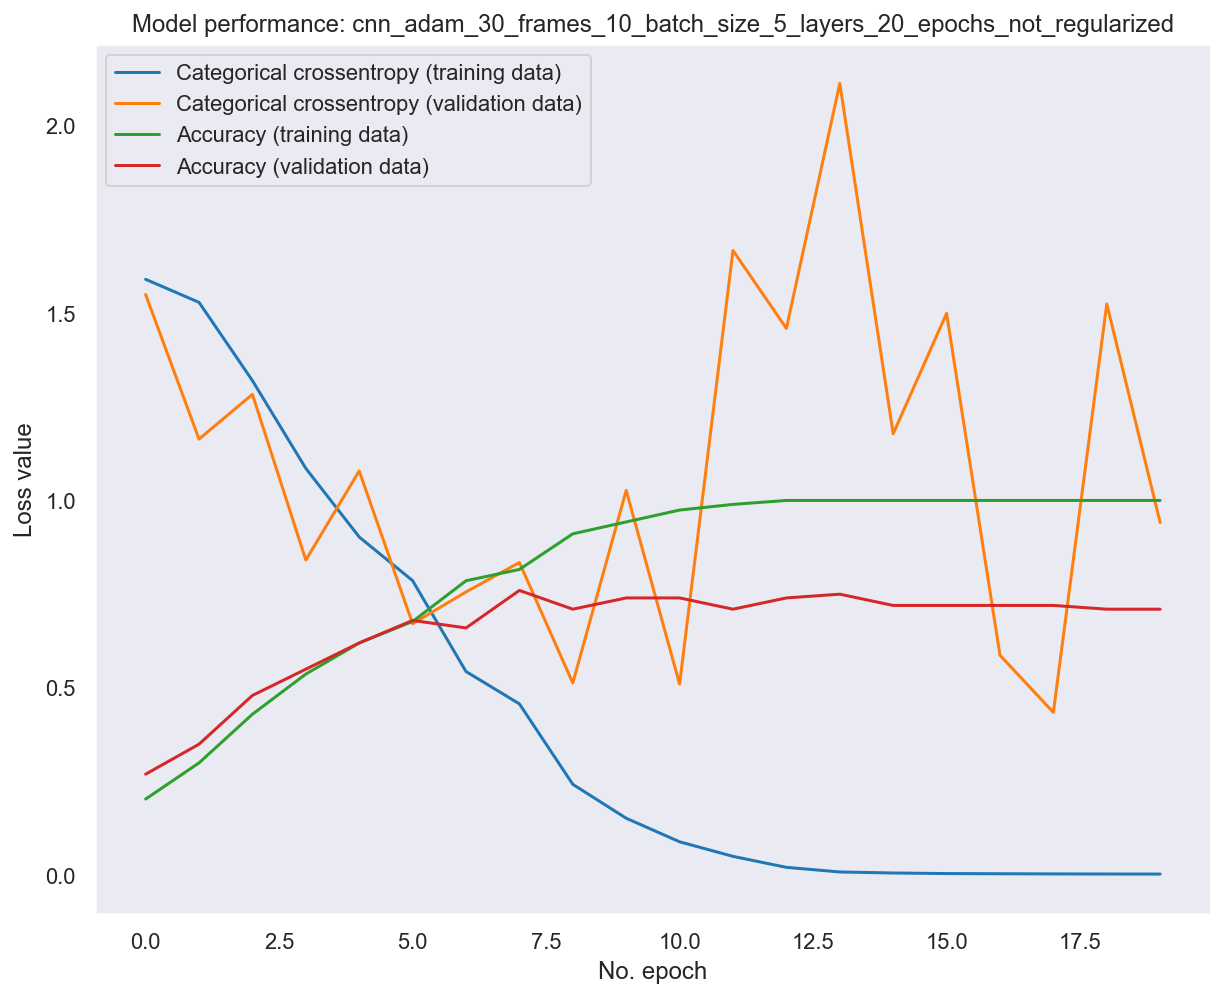

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.5492,0.2700,1.5897,0.2036,0.0010,0,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
1,1.1635,0.3500,1.5282,0.3002,0.0010,1,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
2,1.2829,0.4800,1.3196,0.4299,0.0010,2,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
3,0.8411,0.5500,1.0855,0.5370,0.0010,3,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
4,1.0787,0.6200,0.9025,0.6199,0.0010,4,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
5,0.6713,0.6800,0.7861,0.6772,0.0010,5,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
6,0.7560,0.6600,0.5438,0.7858,0.0010,6,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
7,0.8345,0.7600,0.4575,0.8160,0.0010,7,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
8,0.5130,0.7100,0.2430,0.9110,0.0005,8,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
9,1.0267,0.7400,0.1525,0.9427,0.0005,9,cnn_adam_30_frames_10_batch_size_5_layers_20_e...


In [51]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 20,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True
        }),
        ModelLayer({
            "layer_dim": 16,
        }),
        ModelLayer({
            "layer_dim": 32,
        }),
         ModelLayer({
            "layer_dim": 64,
        }),
        ModelLayer({
            "layer_dim": 64,
            "is_conv_layer":False
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

## Model 3

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 10
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 20
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, filter->(3, 3, 3), is_input_layer->True
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->16, filter->(3, 3, 3), is_input_layer->False
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.2, batch_normalize->True, layer_dim->32, filter->(3, 3, 3), is_input_layer->False
----------------------------------------------------
----------------

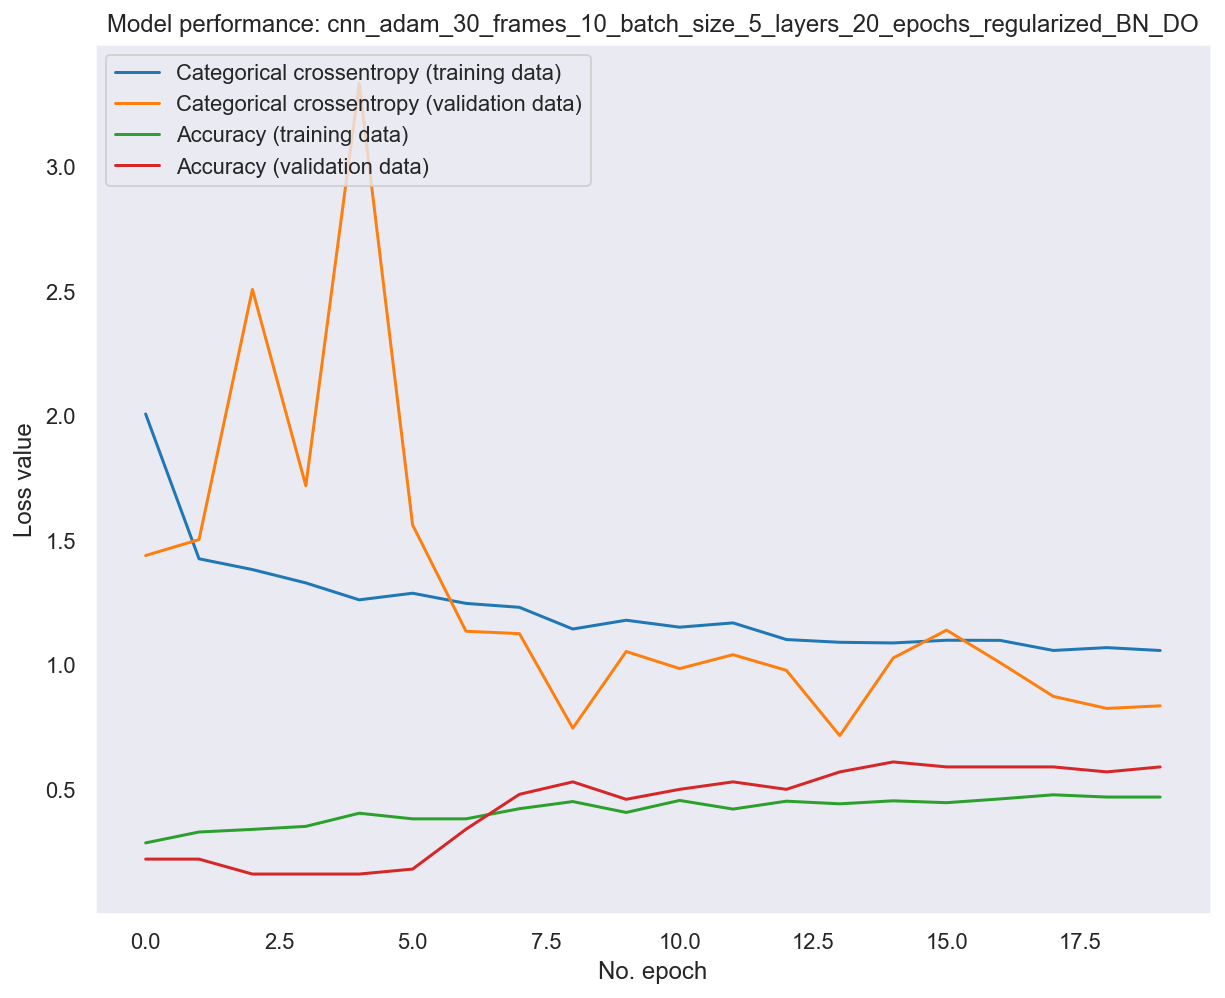

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.4383,0.2200,2.0065,0.2851,0.0010,0,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
1,1.5023,0.2200,1.4253,0.3288,0.0010,1,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
2,2.5061,0.1600,1.3821,0.3394,0.0010,2,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
3,1.7183,0.1600,1.3285,0.3514,0.0005,3,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
4,3.3332,0.1600,1.2605,0.4042,0.0005,4,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
5,1.5611,0.1800,1.2871,0.3816,0.0003,5,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
6,1.1345,0.3400,1.2462,0.3816,0.0003,6,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
7,1.1250,0.4800,1.2305,0.4223,0.0003,7,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
8,0.7456,0.5300,1.1434,0.4510,0.0003,8,cnn_adam_30_frames_10_batch_size_5_layers_20_e...
9,1.0532,0.4600,1.1787,0.4072,0.0003,9,cnn_adam_30_frames_10_batch_size_5_layers_20_e...


In [52]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 10,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 20,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.2
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.2
        }),
        ModelLayer({
            "layer_dim": 64,
            "is_conv_layer":False,
            "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

## Model 4

We can see that after adding regularization, the model is under fitting. Let us increase the number of parameters. 

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 20
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 20
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, filter->(3, 3, 3), is_input_layer->True
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.2, batch_normalize->True, layer_dim->16, filter->(3, 3, 3), is_input_layer->False
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->32, filter->(3, 3, 3), is_input_layer->False
----------------------------------------------------
----------------

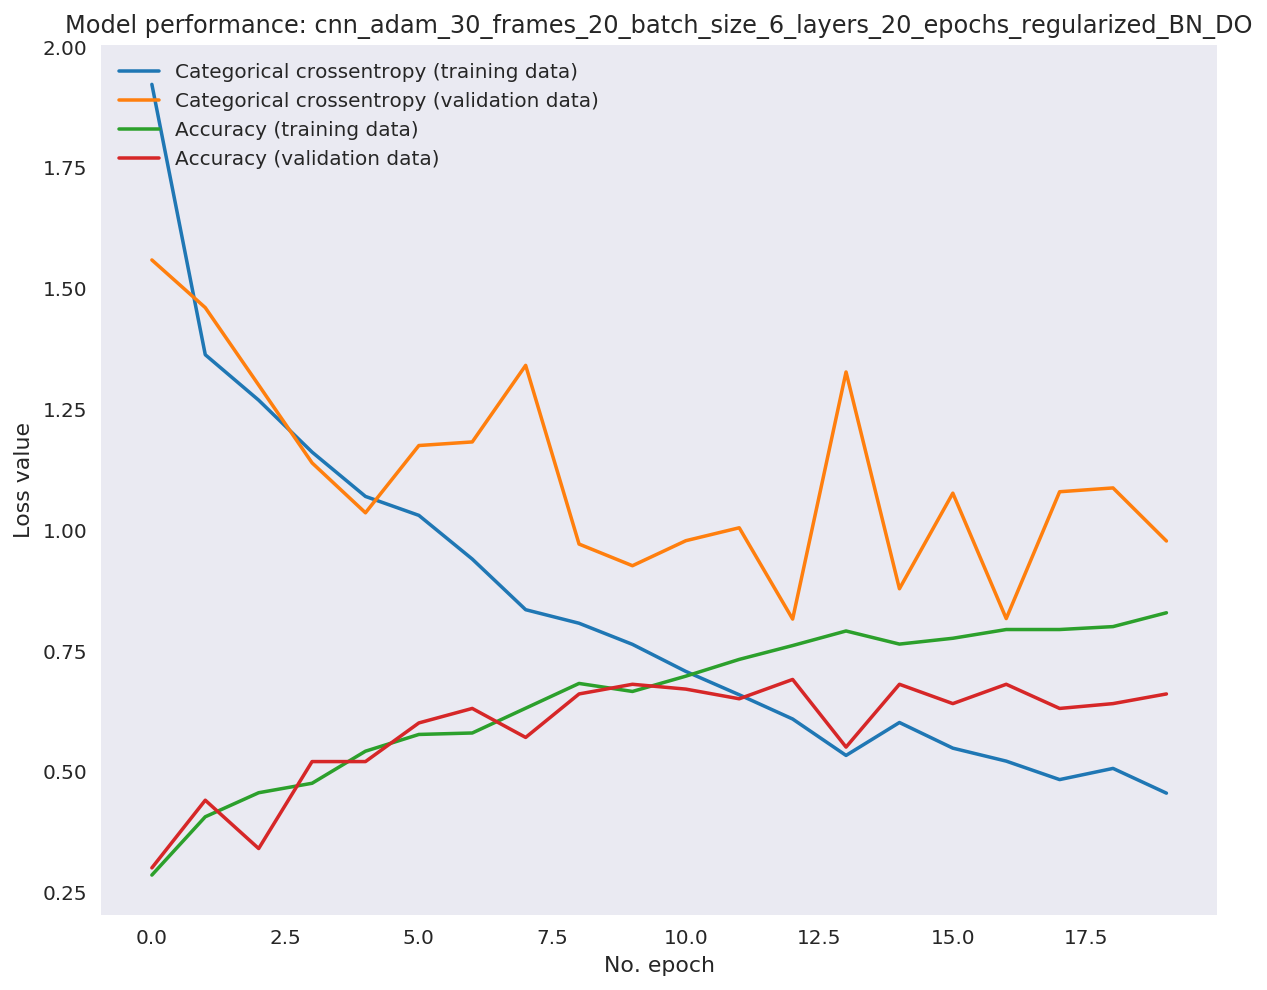

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.5584,0.3000,1.9219,0.2851,0.0010,0,cnn_adam_30_frames_20_batch_size_6_layers_20_e...
1,1.4597,0.4400,1.3622,0.4057,0.0010,1,cnn_adam_30_frames_20_batch_size_6_layers_20_e...
2,1.2994,0.3400,1.2681,0.4555,0.0010,2,cnn_adam_30_frames_20_batch_size_6_layers_20_e...
3,1.1384,0.5200,1.1607,0.4751,0.0010,3,cnn_adam_30_frames_20_batch_size_6_layers_20_e...
4,1.0350,0.5200,1.0689,0.5415,0.0010,4,cnn_adam_30_frames_20_batch_size_6_layers_20_e...
5,1.1743,0.6000,1.0297,0.5762,0.0010,5,cnn_adam_30_frames_20_batch_size_6_layers_20_e...
6,1.1817,0.6300,0.9392,0.5792,0.0010,6,cnn_adam_30_frames_20_batch_size_6_layers_20_e...
7,1.3401,0.5700,0.8344,0.6305,0.0005,7,cnn_adam_30_frames_20_batch_size_6_layers_20_e...
8,0.9703,0.6600,0.8064,0.6817,0.0005,8,cnn_adam_30_frames_20_batch_size_6_layers_20_e...
9,0.9254,0.6800,0.7626,0.6652,0.0005,9,cnn_adam_30_frames_20_batch_size_6_layers_20_e...


In [52]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 20,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.2
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.2
        }),
        ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        }),
         ModelLayer({
            "layer_dim": 64,
            "is_conv_layer":False,
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

## Model 5

The above model gave accuracy of `69%` on validation set and `76%` on training set. We will introduce dropout on the last dense layer.

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 20
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.2, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------

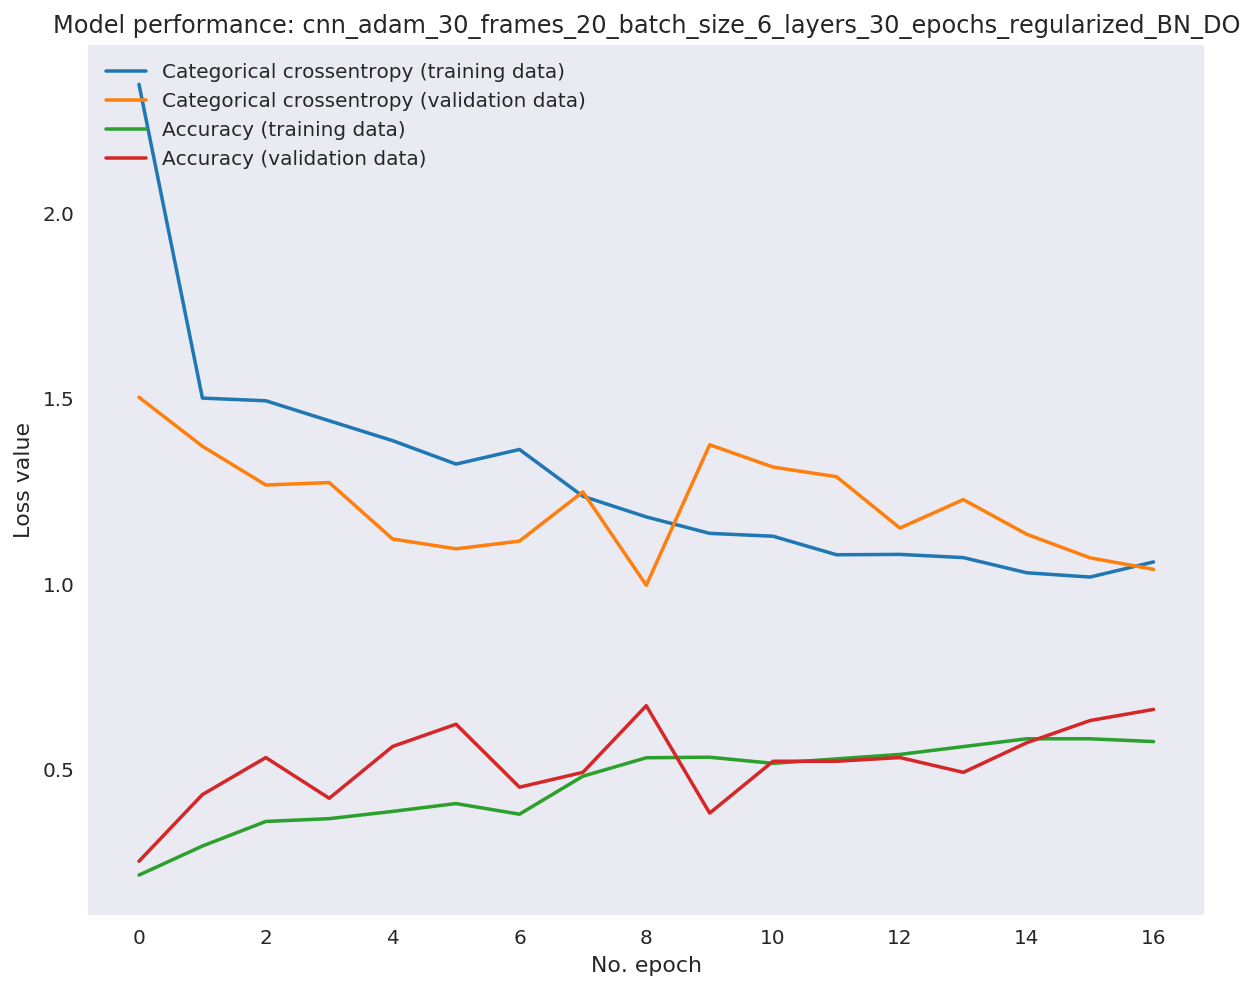

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,1.5029,0.2500,2.3479,0.2127,0.0010,0,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
1,1.3706,0.4300,1.5007,0.2911,0.0010,1,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
2,1.2660,0.5300,1.4935,0.3575,0.0010,2,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
3,1.2726,0.4200,1.4395,0.3650,0.0010,3,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
4,1.1201,0.5600,1.3858,0.3846,0.0010,4,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
5,1.0937,0.6200,1.3225,0.4057,0.0010,5,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
6,1.1145,0.4500,1.3619,0.3771,0.0010,6,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
7,1.2474,0.4900,1.2356,0.4796,0.0010,7,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
8,0.9954,0.6700,1.1798,0.5294,0.0005,8,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
9,1.3747,0.3800,1.1355,0.5309,0.0005,9,cnn_adam_30_frames_20_batch_size_6_layers_30_e...


In [50]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": (0, 30),
    "model_name": "cnn",
    "num_epochs": 30,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.2
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.2
        }),
        ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        }),
         ModelLayer({
            "layer_dim": 64,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

## Model 6

We can see now that the model is now underfitting validation accuracy is less than training accuracy. Let us introduce more weight in the model.

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 20
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------


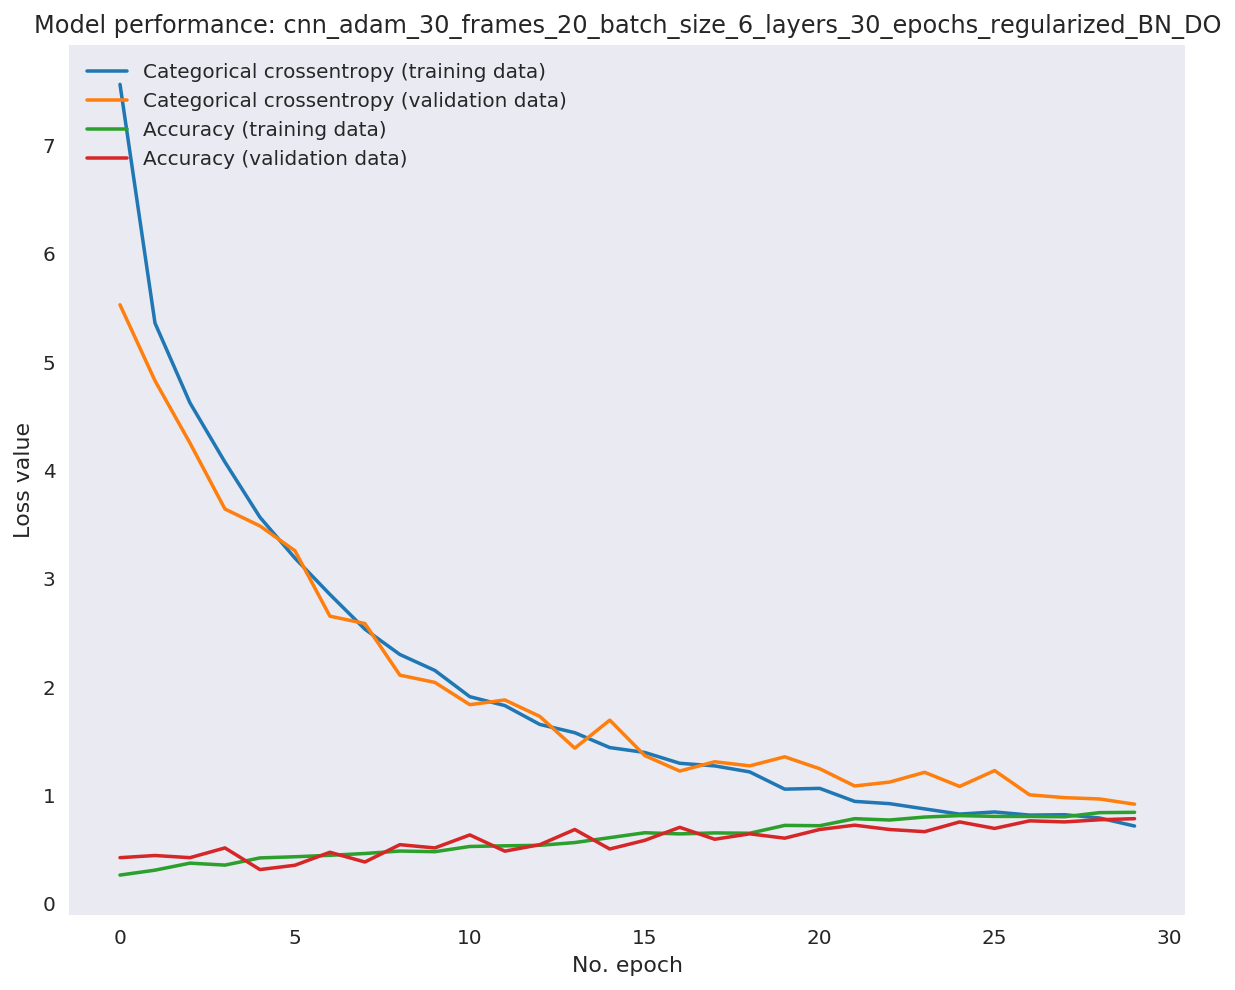

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,5.5236,0.4200,7.5584,0.2594,0.0010,0,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
1,4.8229,0.4400,5.3553,0.3047,0.0010,1,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
2,4.2475,0.4200,4.6185,0.3695,0.0010,2,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
3,3.6383,0.5100,4.0718,0.3514,0.0010,3,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
4,3.4822,0.3100,3.5626,0.4178,0.0010,4,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
5,3.2534,0.3500,3.1853,0.4284,0.0010,5,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
6,2.6492,0.4700,2.8502,0.4419,0.0010,6,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
7,2.5816,0.3800,2.5294,0.4585,0.0010,7,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
8,2.1051,0.5400,2.2955,0.4811,0.0010,8,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
9,2.0378,0.5100,2.1485,0.4751,0.0010,9,cnn_adam_30_frames_20_batch_size_6_layers_30_e...


In [53]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": (0,30),
    "model_name": "cnn",
    "num_epochs": 30,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 256,
            "is_conv_layer":False,
             "dropout":0.5,
            "l2_regularize":0.01
        }),
         ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

We see that the model improved, however, there are ups and downs in the accuracy as `ReduceLROnPlateau` starts reducing the learning rate. Let us reduce the learning rate to `0.0002`.  

Model Params: 
********************************************************
learning_rate -> 0.0002
optmizer -> adam
batch_size -> 20
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------

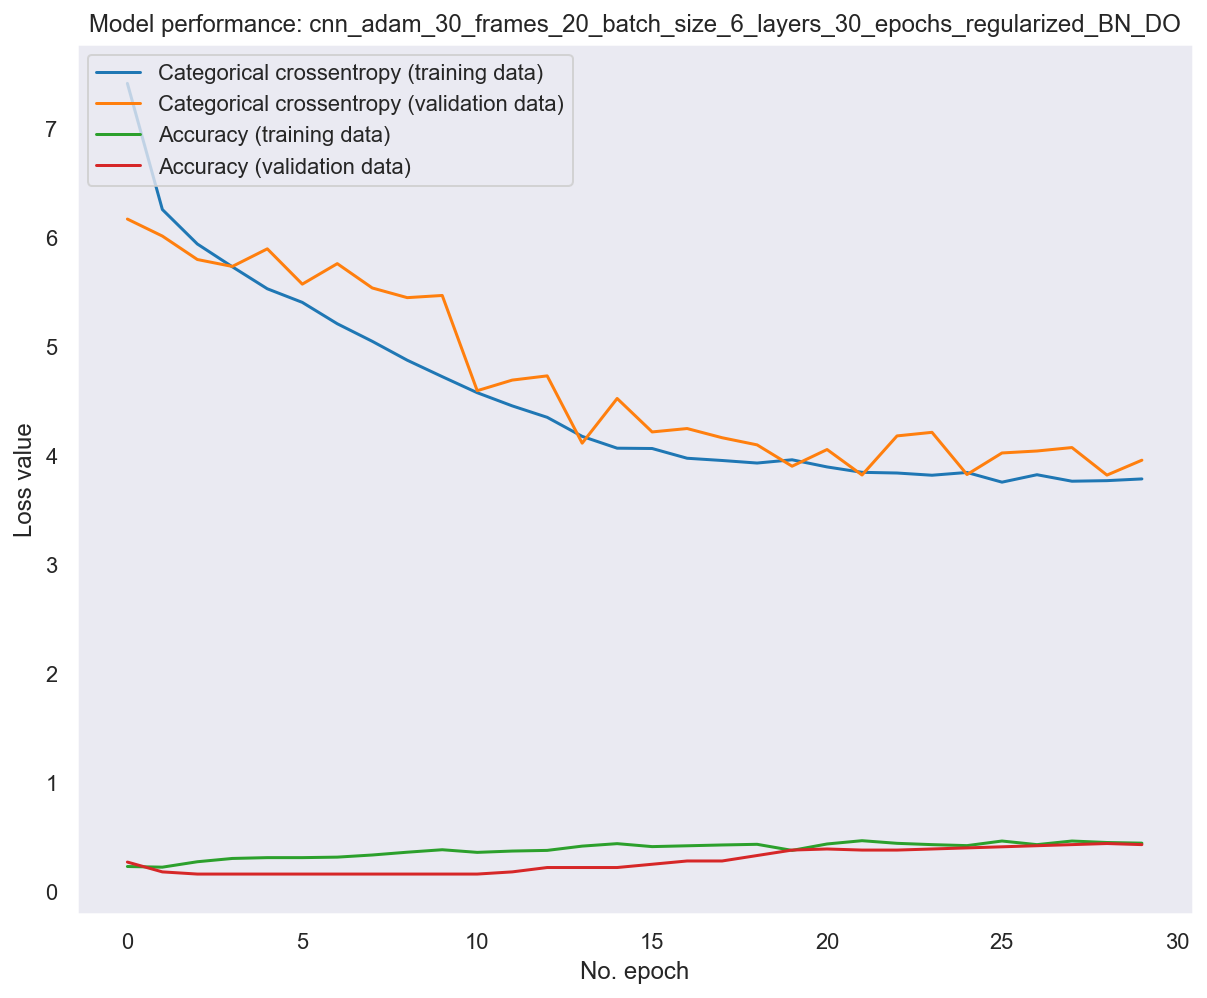

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,6.1667,0.2700,7.4108,0.2293,0.0002,0,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
1,6.0106,0.1800,6.2542,0.2232,0.0002,1,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
2,5.7956,0.1600,5.9379,0.2730,0.0002,2,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
3,5.7320,0.1600,5.7288,0.3032,0.0002,3,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
4,5.8935,0.1600,5.5272,0.3107,0.0002,4,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
5,5.5698,0.1600,5.4025,0.3107,0.0002,5,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
6,5.7578,0.1600,5.2065,0.3152,0.0002,6,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
7,5.5346,0.1600,5.0454,0.3348,0.0002,7,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
8,5.4459,0.1600,4.8720,0.3605,0.0002,8,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
9,5.4659,0.1600,4.7214,0.3831,0.0002,9,cnn_adam_30_frames_20_batch_size_6_layers_30_e...


In [47]:
params = {
    "learning_rate": 0.0002,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": (0,30),
    "model_name": "cnn",
    "num_epochs": 30,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 256,
            "is_conv_layer":False,
             "dropout":0.5,
            "l2_regularize":0.01
        }),
         ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 20
video_frames -> [ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23 24 26 27 29]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
-------------------------------------------------

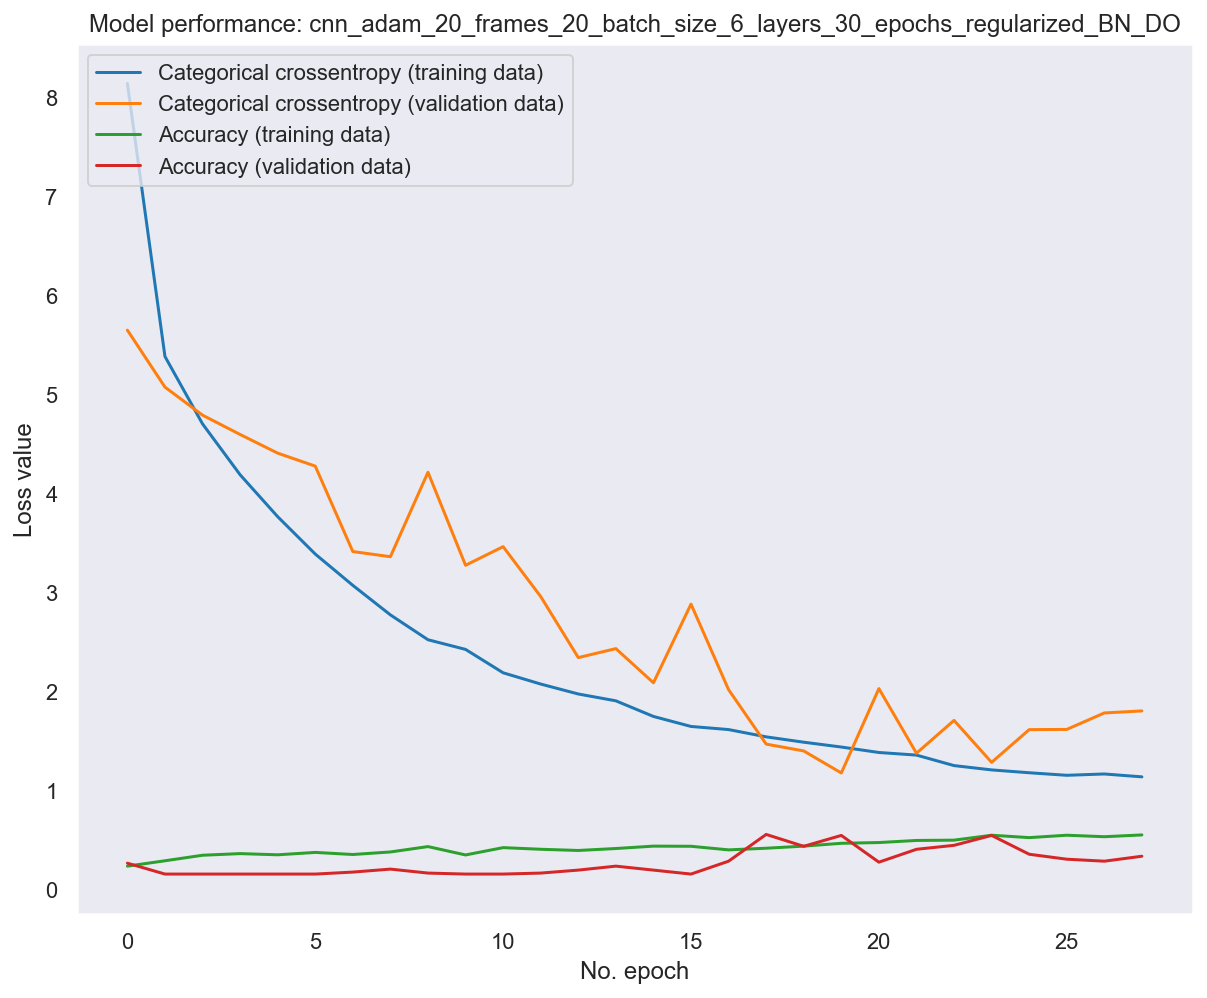

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,5.6498,0.2700,8.1402,0.2398,0.0010,0,cnn_adam_20_frames_20_batch_size_6_layers_30_e...
1,5.0747,0.1600,5.3840,0.2941,0.0010,1,cnn_adam_20_frames_20_batch_size_6_layers_30_e...
2,4.7917,0.1600,4.7037,0.3499,0.0010,2,cnn_adam_20_frames_20_batch_size_6_layers_30_e...
3,4.5966,0.1600,4.1901,0.3665,0.0010,3,cnn_adam_20_frames_20_batch_size_6_layers_30_e...
4,4.4083,0.1600,3.7669,0.3544,0.0010,4,cnn_adam_20_frames_20_batch_size_6_layers_30_e...
5,4.2772,0.1600,3.3897,0.3786,0.0010,5,cnn_adam_20_frames_20_batch_size_6_layers_30_e...
6,3.4151,0.1800,3.0738,0.3575,0.0010,6,cnn_adam_20_frames_20_batch_size_6_layers_30_e...
7,3.3629,0.2100,2.7758,0.3831,0.0010,7,cnn_adam_20_frames_20_batch_size_6_layers_30_e...
8,4.2154,0.1700,2.5249,0.4374,0.0010,8,cnn_adam_20_frames_20_batch_size_6_layers_30_e...
9,3.2765,0.1600,2.4274,0.3529,0.0010,9,cnn_adam_20_frames_20_batch_size_6_layers_30_e...


In [48]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": 20,
    "model_name": "cnn",
    "num_epochs": 30,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 256,
            "is_conv_layer":False,
             "dropout":0.5,
            "l2_regularize":0.01
        }),
         ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 20
video_frames -> [ 0  1  3  4  5  6  8  9 10 11 13 14 15 16 18 19 20 21 23 24 25 26 28 29]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
-------------------------------------

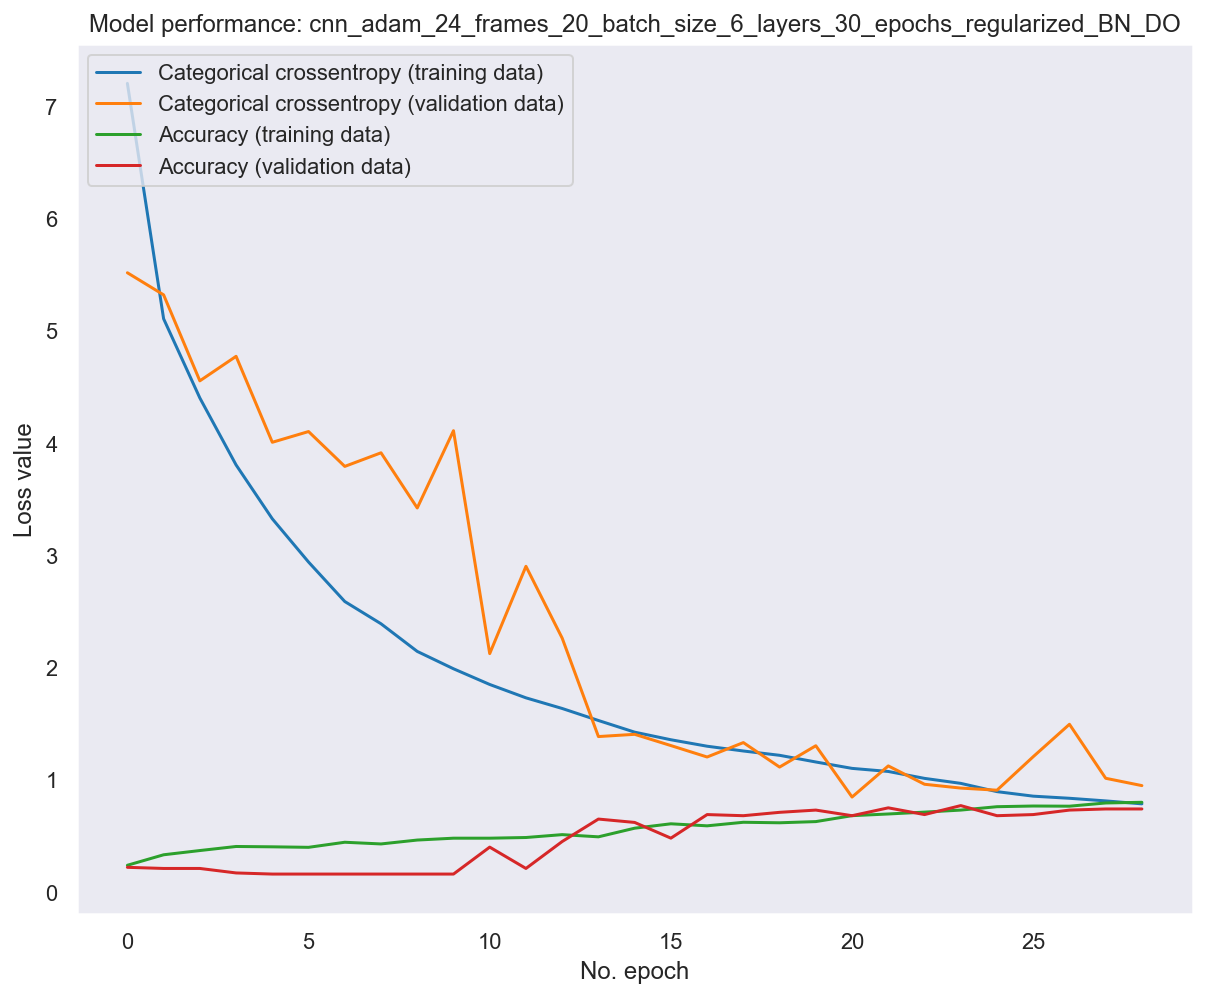

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,5.5172,0.2200,7.2043,0.2383,0.0010,0,cnn_adam_24_frames_20_batch_size_6_layers_30_e...
1,5.3203,0.2100,5.1074,0.3318,0.0010,1,cnn_adam_24_frames_20_batch_size_6_layers_30_e...
2,4.5542,0.2100,4.4017,0.3695,0.0010,2,cnn_adam_24_frames_20_batch_size_6_layers_30_e...
3,4.7726,0.1700,3.8051,0.4057,0.0010,3,cnn_adam_24_frames_20_batch_size_6_layers_30_e...
4,4.0068,0.1600,3.3250,0.4027,0.0010,4,cnn_adam_24_frames_20_batch_size_6_layers_30_e...
5,4.1025,0.1600,2.9398,0.3982,0.0010,5,cnn_adam_24_frames_20_batch_size_6_layers_30_e...
6,3.7919,0.1600,2.5882,0.4434,0.0010,6,cnn_adam_24_frames_20_batch_size_6_layers_30_e...
7,3.9132,0.1600,2.3899,0.4284,0.0010,7,cnn_adam_24_frames_20_batch_size_6_layers_30_e...
8,3.4217,0.1600,2.1436,0.4630,0.0010,8,cnn_adam_24_frames_20_batch_size_6_layers_30_e...
9,4.1100,0.1600,1.9890,0.4796,0.0010,9,cnn_adam_24_frames_20_batch_size_6_layers_30_e...


In [49]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": 24,
    "model_name": "cnn",
    "num_epochs": 30,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 256,
            "is_conv_layer":False,
             "dropout":0.5,
            "l2_regularize":0.01
        }),
         ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 20
video_frames -> [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------------------

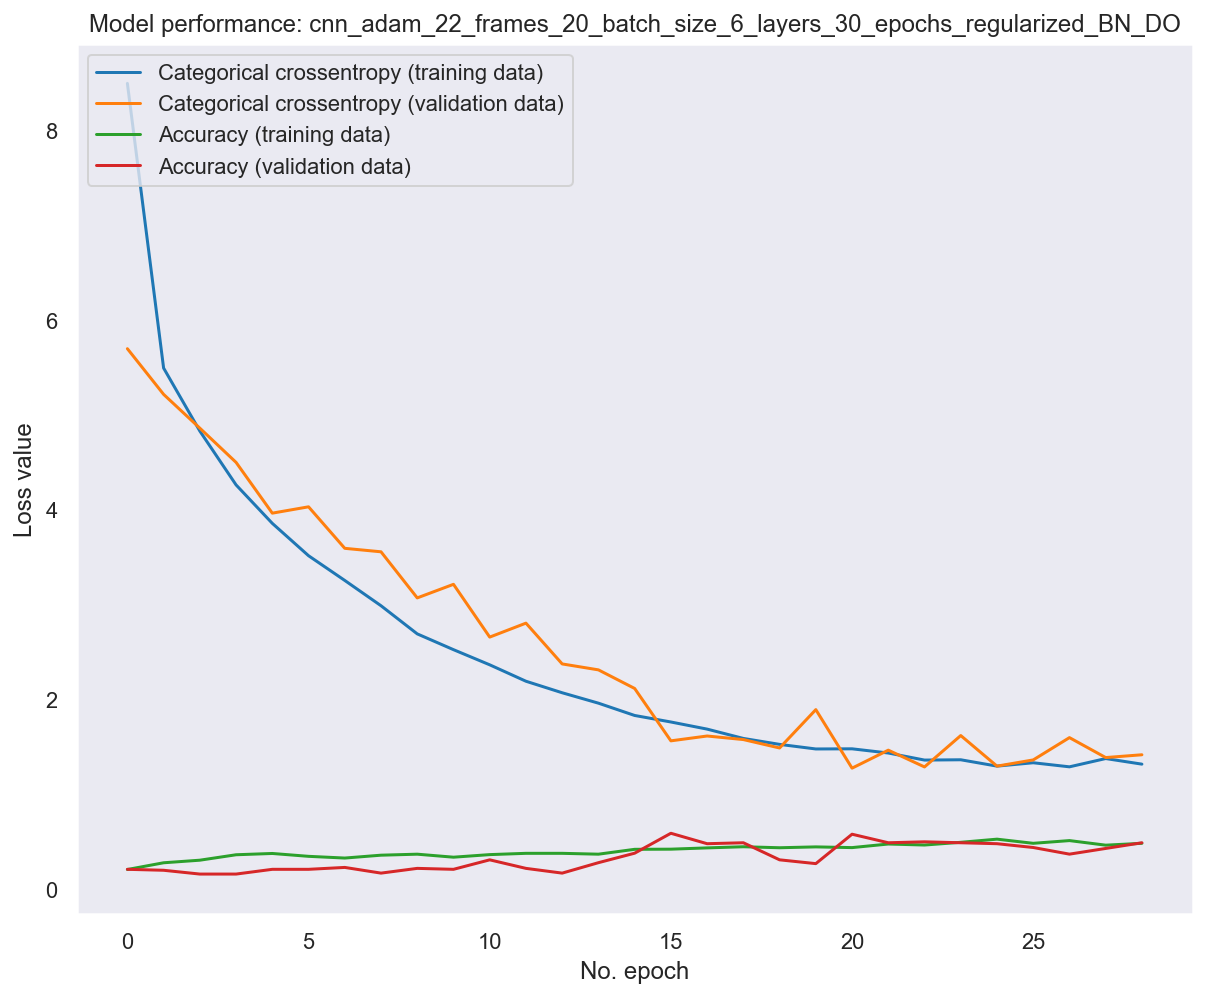

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,5.6976,0.2100,8.4940,0.2081,0.0010,0,cnn_adam_22_frames_20_batch_size_6_layers_30_e...
1,5.2162,0.2000,5.4934,0.2790,0.0010,1,cnn_adam_22_frames_20_batch_size_6_layers_30_e...
2,4.8599,0.1600,4.8292,0.3062,0.0010,2,cnn_adam_22_frames_20_batch_size_6_layers_30_e...
3,4.4991,0.1600,4.2617,0.3635,0.0010,3,cnn_adam_22_frames_20_batch_size_6_layers_30_e...
4,3.9641,0.2100,3.8565,0.3771,0.0010,4,cnn_adam_22_frames_20_batch_size_6_layers_30_e...
5,4.0308,0.2100,3.5153,0.3469,0.0010,5,cnn_adam_22_frames_20_batch_size_6_layers_30_e...
6,3.5933,0.2300,3.2547,0.3288,0.0010,6,cnn_adam_22_frames_20_batch_size_6_layers_30_e...
7,3.5567,0.1700,2.9882,0.3590,0.0010,7,cnn_adam_22_frames_20_batch_size_6_layers_30_e...
8,3.0708,0.2200,2.6916,0.3695,0.0010,8,cnn_adam_22_frames_20_batch_size_6_layers_30_e...
9,3.2140,0.2100,2.5252,0.3379,0.0010,9,cnn_adam_22_frames_20_batch_size_6_layers_30_e...


In [50]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": (4,26),
    "model_name": "cnn",
    "num_epochs": 30,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 256,
            "is_conv_layer":False,
             "dropout":0.5,
            "l2_regularize":0.01
        }),
         ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 20
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(2, 2, 2)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(2, 2, 2)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(2, 2, 2)
----------------------------------------------------


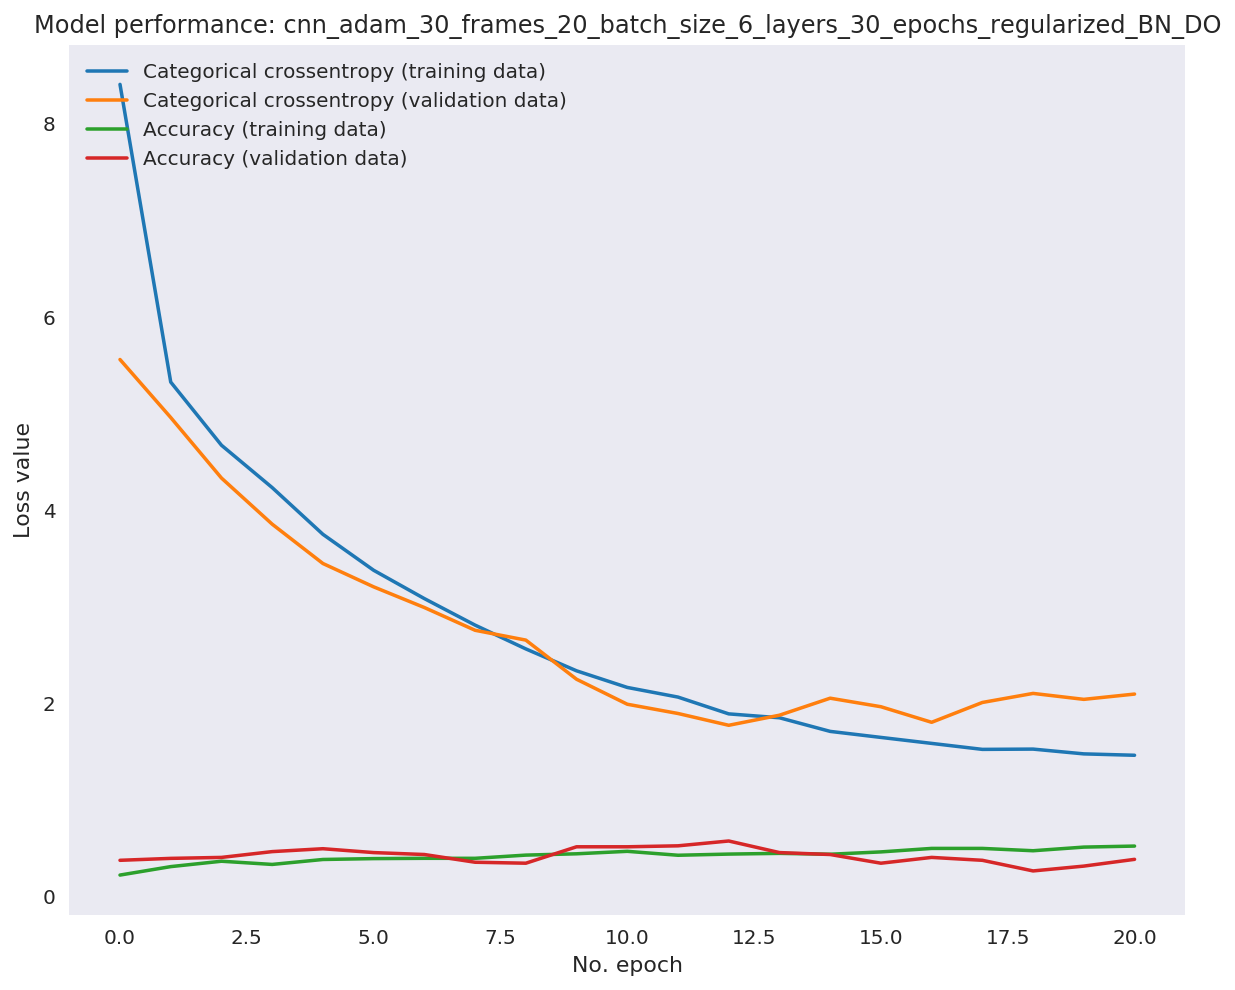

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,5.5554,0.3700,8.4043,0.2172,0.0010,0,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
1,4.9549,0.3900,5.3220,0.3047,0.0010,1,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
2,4.3282,0.4000,4.6680,0.3605,0.0010,2,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
3,3.8505,0.4600,4.2292,0.3273,0.0010,3,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
4,3.4433,0.4900,3.7454,0.3786,0.0010,4,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
5,3.2016,0.4500,3.3732,0.3876,0.0010,5,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
6,2.9874,0.4300,3.0799,0.3906,0.0010,6,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
7,2.7518,0.3500,2.8052,0.3906,0.0010,7,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
8,2.6501,0.3400,2.5590,0.4238,0.0010,8,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
9,2.2448,0.5100,2.3321,0.4374,0.0010,9,cnn_adam_30_frames_20_batch_size_6_layers_30_e...


In [47]:
# To start from 

params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": (0,30),
    "model_name": "cnn",
    "num_epochs": 30,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True,
            "filter":(2,2,2)
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.25,
            "filter":(2,2,2)
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.25,
            "filter":(2,2,2)
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.25,
            "filter":(2,2,2)
        }),
        ModelLayer({
            "layer_dim": 256,
            "is_conv_layer":False,
             "dropout":0.5,
            "l2_regularize":0.01
        }),
         ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 20
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(1, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(3, 1, 3)
----------------------------------------------------


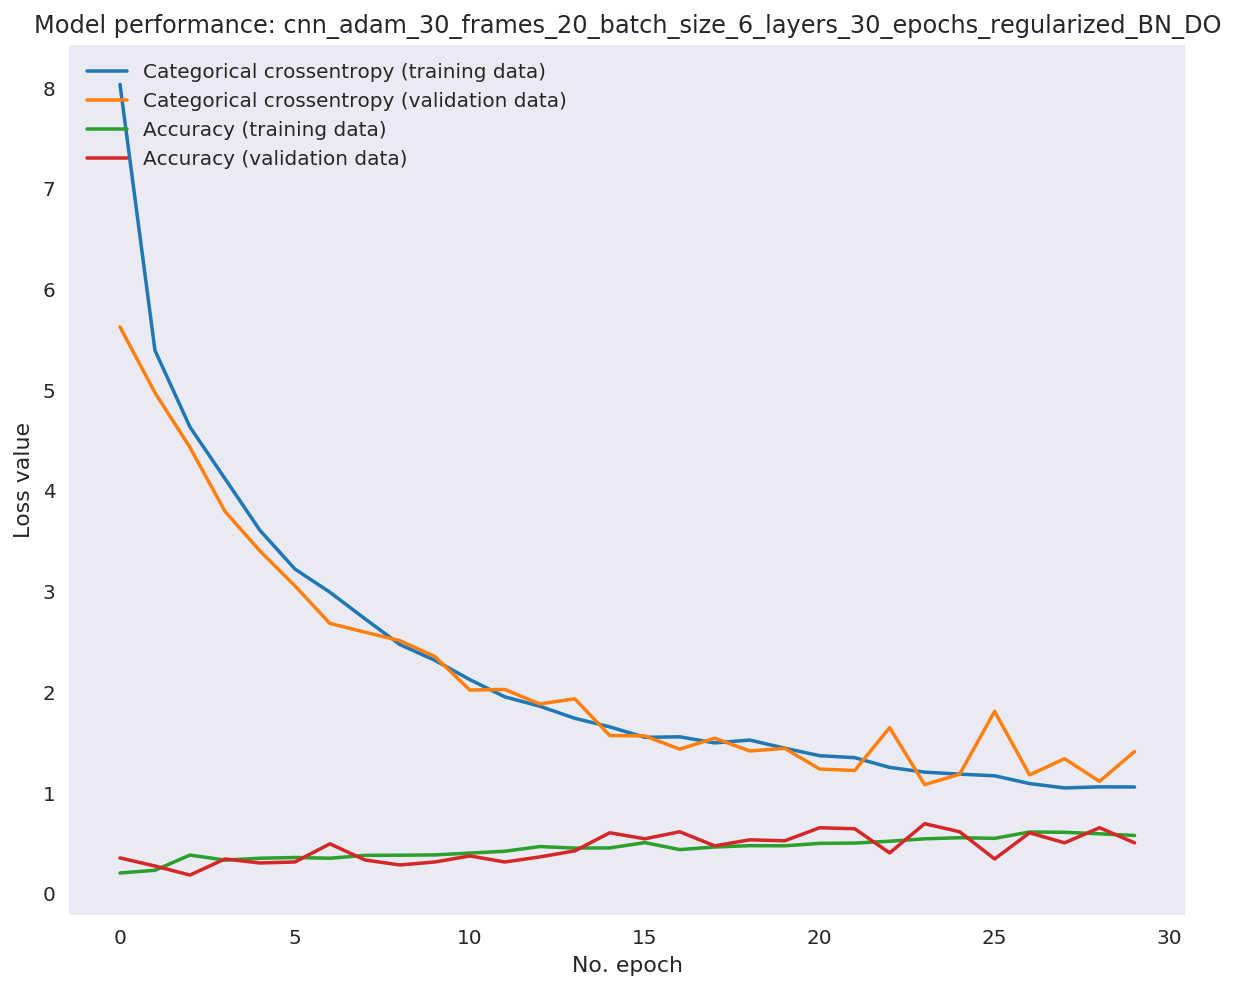

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,5.6226,0.3500,8.0311,0.2006,0.0010,0,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
1,4.9694,0.2700,5.3890,0.2278,0.0010,1,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
2,4.4267,0.1800,4.6290,0.3786,0.0010,2,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
3,3.7915,0.3400,4.1167,0.3288,0.0010,3,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
4,3.3987,0.3000,3.6028,0.3469,0.0010,4,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
5,3.0521,0.3100,3.2187,0.3544,0.0010,5,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
6,2.6787,0.4900,2.9884,0.3469,0.0010,6,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
7,2.5921,0.3300,2.7252,0.3756,0.0010,7,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
8,2.5075,0.2800,2.4692,0.3771,0.0010,8,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
9,2.3496,0.3100,2.3122,0.3801,0.0010,9,cnn_adam_30_frames_20_batch_size_6_layers_30_e...


In [48]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": (0,30),
    "model_name": "cnn",
    "num_epochs": 30,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.25,
            "filter":(1,3,3)
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.25,
            "filter":(3,1,3)
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.25,
            "filter":(3,3,1)
        }),
        ModelLayer({
            "layer_dim": 256,
            "is_conv_layer":False,
             "dropout":0.5,
            "l2_regularize":0.01
        }),
         ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
********************************************************
learning_rate -> 0.002
optmizer -> adam
batch_size -> 20
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------


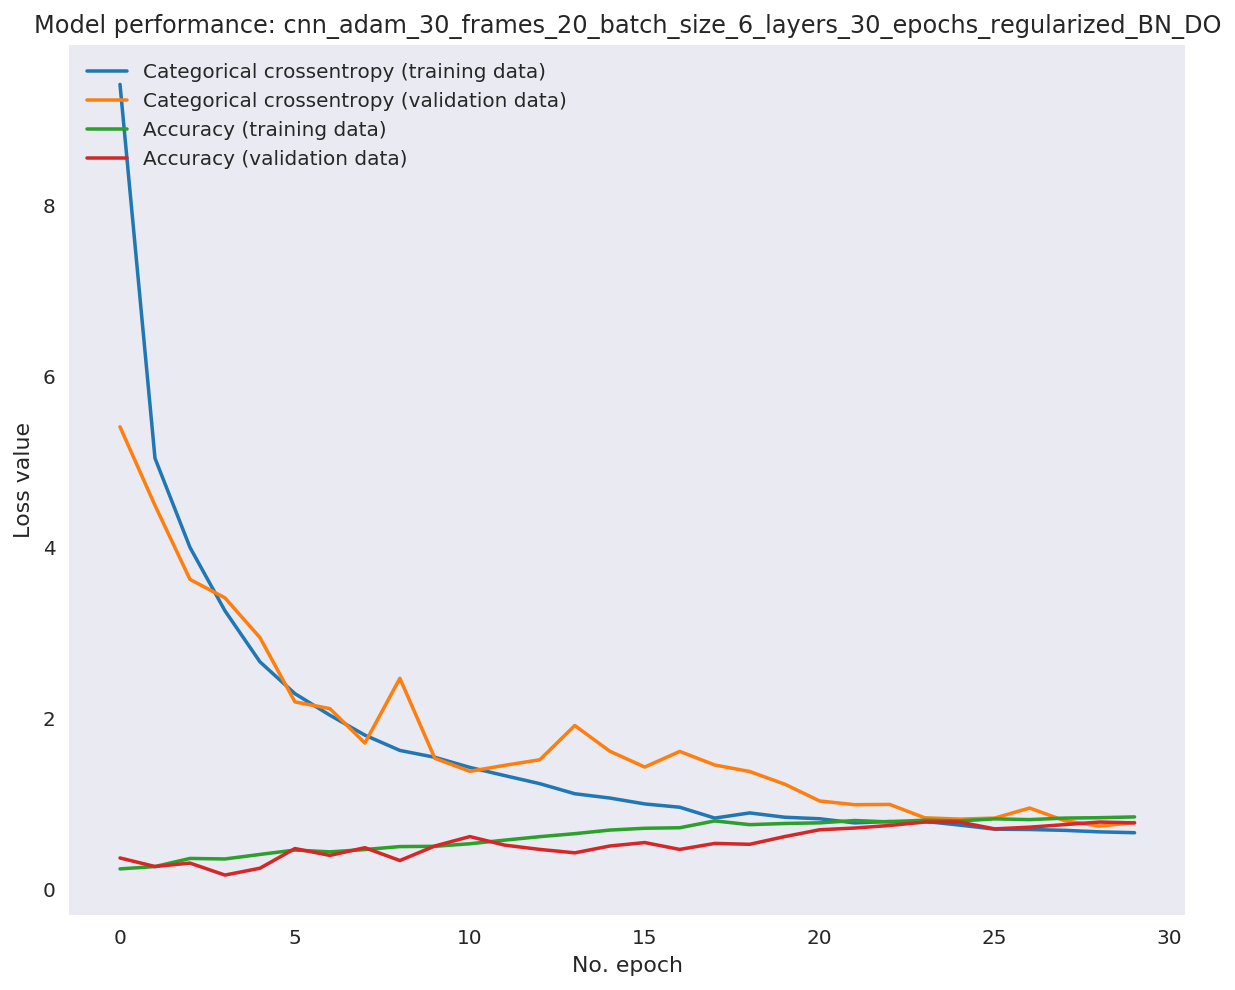

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,5.4023,0.3600,9.4073,0.2323,0.0020,0,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
1,4.4826,0.2600,5.0352,0.2594,0.0020,1,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
2,3.6180,0.3000,3.9925,0.3544,0.0020,2,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
3,3.4018,0.1600,3.2510,0.3484,0.0020,3,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
4,2.9372,0.2400,2.6538,0.4012,0.0020,4,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
5,2.1855,0.4700,2.2816,0.4525,0.0020,5,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
6,2.1064,0.3900,2.0295,0.4314,0.0020,6,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
7,1.7038,0.4800,1.7964,0.4585,0.0020,7,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
8,2.4605,0.3300,1.6177,0.4932,0.0020,8,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
9,1.5253,0.5000,1.5373,0.4962,0.0020,9,cnn_adam_30_frames_20_batch_size_6_layers_30_e...


In [50]:
params = {
    "learning_rate": 0.002,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": (0,30),
    "model_name": "cnn",
    "num_epochs": 30,
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 256,
            "is_conv_layer":False,
             "dropout":0.5,
            "l2_regularize":0.01
        }),
         ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)

Model Params: 
********************************************************
learning_rate -> 0.001
optmizer -> adam
batch_size -> 20
video_frames -> [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
num_epochs -> 30
image_shape -> (120, 120)
decay_learning_rate -> False
augmentors -> []
Layers: 
----------------------------------------------------
is_conv_layer->True, batch_normalize->True, layer_dim->8, is_input_layer->True, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->16, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------
----------------------------------------------------
is_conv_layer->True, dropout->0.25, batch_normalize->True, layer_dim->32, is_input_layer->False, filter->(3, 3, 3)
----------------------------------------------------


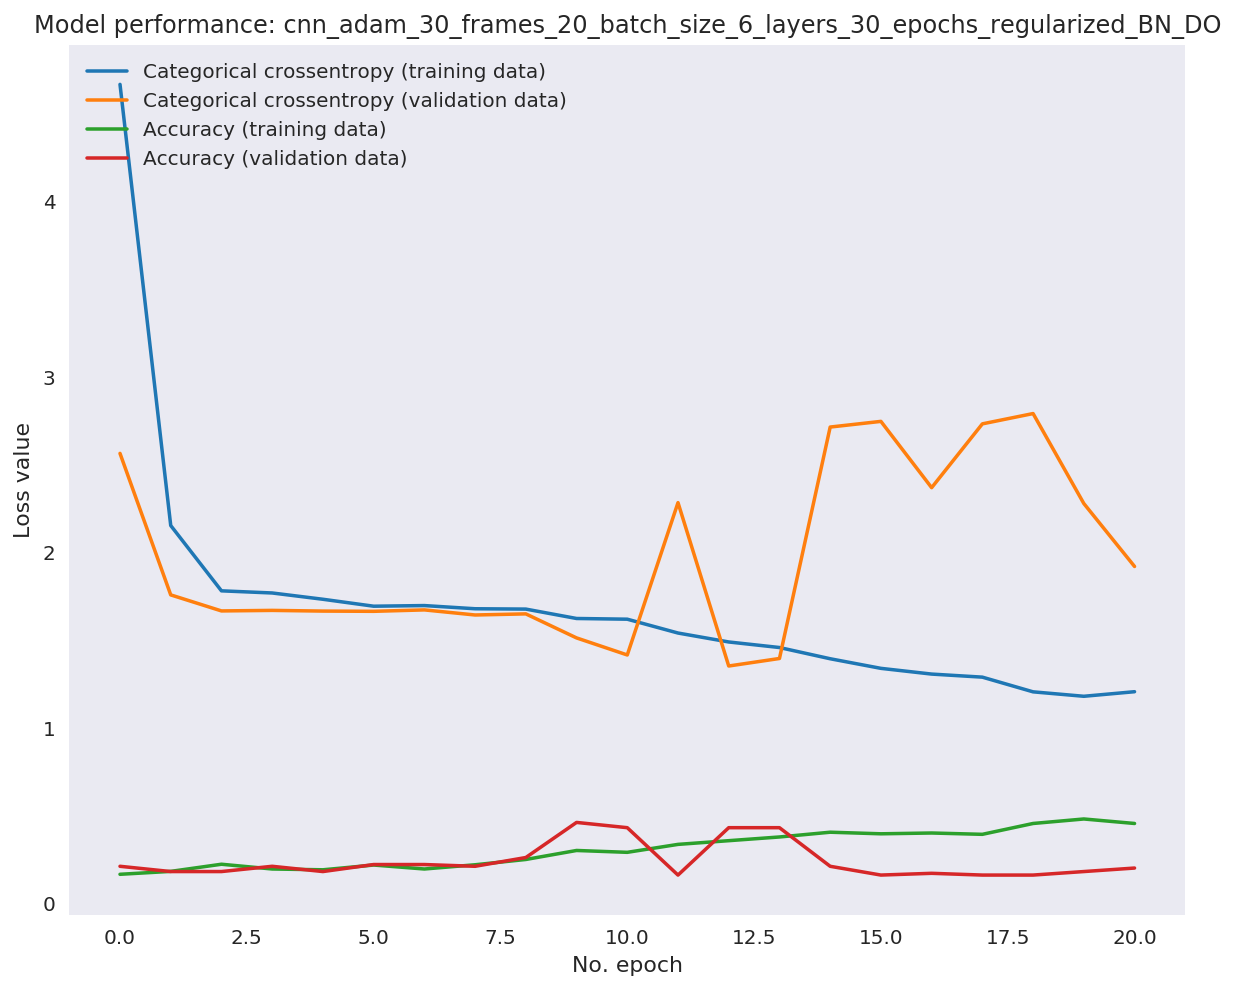

,val_loss,val_categorical_accuracy,loss,categorical_accuracy,lr,epoch,name
0,2.5631,0.2100,4.6662,0.1644,0.0010,0,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
1,1.7567,0.1800,2.1520,0.1810,0.0010,1,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
2,1.6653,0.1800,1.7798,0.2217,0.0010,2,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
3,1.6684,0.2100,1.7676,0.1946,0.0010,3,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
4,1.6644,0.1800,1.7318,0.1900,0.0010,4,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
5,1.6631,0.2200,1.6922,0.2172,0.0010,5,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
6,1.6712,0.2200,1.6958,0.1946,0.0010,6,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
7,1.6422,0.2100,1.6777,0.2187,0.0010,7,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
8,1.6485,0.2600,1.6758,0.2489,0.0010,8,cnn_adam_30_frames_20_batch_size_6_layers_30_e...
9,1.5115,0.4600,1.6222,0.3002,0.0010,9,cnn_adam_30_frames_20_batch_size_6_layers_30_e...


In [52]:
params = {
    "learning_rate": 0.001,
    "optmizer": "adam",
    "batch_size": 20,
    "frames": (0,30),
    "model_name": "cnn",
    "num_epochs": 30,
    "activation":"sigmoid",
    "layers": [
        ModelLayer({
            "layer_dim": 8,
            "is_input_layer": True,
            "batch_normalize":True
        }),
        ModelLayer({
            "layer_dim": 16,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 32,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 64,
            "batch_normalize":True,
            "dropout":0.25
        }),
        ModelLayer({
            "layer_dim": 256,
            "is_conv_layer":False,
             "dropout":0.5,
            "l2_regularize":0.01
        }),
         ModelLayer({
            "layer_dim": 128,
            "is_conv_layer":False,
             "dropout":0.5
        })
    ],
    "image_shape": (120, 120)
}
model_param = ModelParam(params)
model = create_cnn_model(model_param)
df = run_model(model, model_param)
collect_stats(df)